# More loss functions & change-of-basis

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

Mike Gelbart

In [1]:
import numpy as np
import numpy.random as npr
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import scipy.special
from scipy.optimize import approx_fprime

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%autosave 0

Autosave disabled


In [2]:
matplotlib.rcParams.update({'font.size': 16})

## Admin

- Monday is a holiday (no class).
- If you don't like Jupyter lectures, don't worry - we'll be switching back on Wednesday.
- a3 released, due in a week from today.
- List of midterm topics will be posted soon.
- End of today: a3 material covered.
- IMHO last class and today are two of the most important lectures in CPSC 340 (no pressure!).

In [3]:
def gen_outlier_data(n=40,Noutliers=3):
    # generate random data
    x = np.random.randn(n)
    y = 3*x
    # add random outliers
    y[:Noutliers] = -3*(x[:Noutliers]+np.random.randn(Noutliers)*0.1)

    X = x[:,None] # reshape for sklearn

    return X,y

## Smooth approximations and the Huber loss

- The absolute value (L1) loss, $ f(w) = \sum_{i=1}^n\left|w^T x_i-y_i\right| $ is **non-smooth**. 
- Gradient descent not guaranteed to converge with constant $\alpha$. 
- One solution: use a **smooth approximation** to the loss. 
- For example, we can minimize the **Huber** objective

$$ \sum_{i=1}^n h \left( y_i-w^\top x_i\right) $$

where $$h(z) \equiv \begin{cases} 
      \frac{1}{2} z^2 & \textrm{if} \; |z|\leq 1 \\   |z|-\frac12 & \textrm{if} \; |z|>1
   \end{cases} $$

with gradient descent. This will hopefully give us robust regression because big distances aren't amplified in the objective.



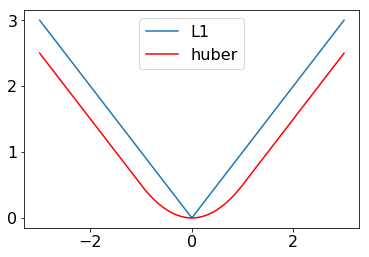

In [4]:
huber = lambda z: 0.5*z**2*(np.abs(z)<=1) + (np.abs(z)-0.5)*(np.abs(z)>1)

grid = np.linspace(-3,3,1000)
plt.plot(grid, np.abs(grid), label="L1")
plt.plot(grid, huber(grid), 'r', label="huber")
plt.legend()
plt.show()

(BONUS "SLIDE")

For linear regression in one dimension the Huber objective becomes

$$f(w,\beta)=\displaystyle \sum_{i=1}^n h\left(w x_i + \beta - y_i\right) $$

The gradient is

$$\frac{\partial f}{\partial w} = \sum_{i=1}^n  x_i h'\left( w x_i +\beta - y_i\right)$$ 

$$\frac{\partial f}{\partial \beta} = \sum_{i=1}^n  h'\left(w x_i +\beta - y_i\right)$$ 

where $$h'(z) = \begin{cases} 
       z & \textrm{if} \; |z|\leq 1 \\   \textrm{sign}(z) & \textrm{if} \; |z|>1
   \end{cases} $$
   
Minimizing this objective yields the robust fit, and in general is a very sensible thing to do!

w = 2.989903
b = 0.041116


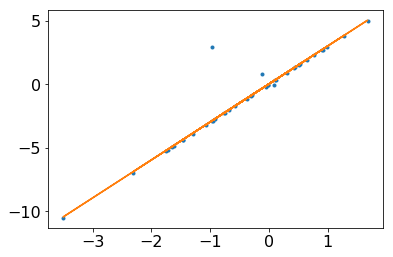

In [5]:
X,y = gen_outlier_data()
x=X.flatten()

w = 0
β = 0
α = 0.01

Nsteps = 1000
yhat = lambda x,w,b: w*x+b

huber_deriv = lambda z: z*(np.abs(z)<=1) + np.sign(z)*(np.abs(z)>1)

for t in range(Nsteps):
    dLdw = -np.sum(x*huber_deriv(y-yhat(x,w,β)))
    dLdβ = -np.sum(huber_deriv(y-yhat(x,w,β)))
    w -= α*dLdw
    β -= α*dLdβ
    
print("w = %f" % w)
print("b = %f" % β)

plt.plot(x,y,'.')
plt.plot(x,w*x+β);

## Log-sum-exp approximation 

- The log-sum-exp approximiation is a mathematical approximation, totally apart from machine learning:

$$\displaystyle \max_i\{z_i\} \approx \log \left(\sum_i \exp(z_i)\right)$$

- We will use this several times in the course, including in a3
- The intuition is that the largest element is magnified exponentially, so we can roughly neglect the rest
  - This reduces it to $\log \left(\sum_i \exp(z_i)\right) \approx \log\left(\exp(\max_i\{z_i\})\right)=\max_i\{z_i\}$

In [6]:
nums = [2,20,5,-100,7]
np.log(np.sum(np.exp(nums))) # this is a good approximation

20.000002581458375

In [7]:
nums = [2,20,19.99,-100,7]
np.log(np.sum(np.exp(nums))) # here it's less good because the runner-up is close

20.688160823975753

One use of log-sum-exp:

- One can rewrite $|z|$ as $\max\{z,-z\}$ (more on this below).
- You can then apply log-sum-exp to this max, and get a smooth approximation of $z$.
- This is an alternative to the Huber loss, and appears on a3. 

Another use of log-sum-exp: brittle regression.

## Brittle regression

- Brittle regression is the opposite of robust regression: we want to minimize the maximum distance to a point.
- A possible loss function is $f(w)=\|Xw-y\|_\infty$ where $\|z\|_\infty\equiv \max_i\{|z_i|\}$. 
- Applying log-sum-exp to the max yields $f(w)=\log \sum_{i=1}^n \exp \left( |w^Tx_i - y_i | \right)$



Confusion warning:

- Robust regression and brittle regression are the opposite of each other
- But both losses are non-smooth
- The log-sum-exp approximation can help in both cases, since both can be written in terms of a max

### Digression: overloading the definition of "max" (or "min") 


| In words  |  In math notation  |  Output type  |  In Python |
|-----------|-----------|---------------|------------|
| maximizing a function over its domain | $\max_x f(x)$ | same type as $x$ (a number, a vector, ...) | `scipy.optimize.minimize` |
| selecting the largest element from a set | $\max(\{a,b\})$ | a number | `np.max` |
| a function given by the max of two other functions | $\max(f(x),g(x))$ | a **function** | `np.maximum` | 

Case (3) seems to confuse a lot of students. Here are some examples...

#### Case 1

$\displaystyle \min_x \, (x-5)^2+3$

In [8]:
result = minimize(lambda x: (x-5)**2+3, np.random.rand())
print("min =", result.fun)
print("arg min =", result.x)

min = 3.0
arg min = [4.99999999]


#### Case 2

$\max \left( \{9, -34, 100, 7\} \right)$

In [9]:
x = [9,-34,100,7]
print(np.max(x))
print(np.argmax(x))

100
2


#### Case 3

$f(x)=\max(x^2, \sqrt{x})$

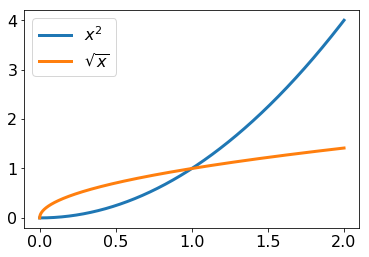

In [10]:
x = np.linspace(0,2,1000)
f = lambda z: z**2
g = lambda z: np.sqrt(z)
plt.plot(x,f(x), linewidth=3, label="$x^2$")
plt.plot(x,g(x), linewidth=3, label="$\sqrt{x}$");
plt.legend();

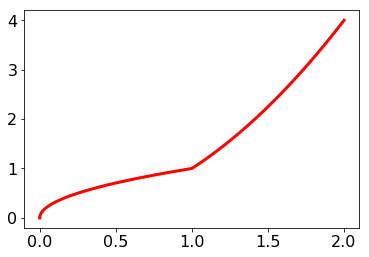

In [11]:
plt.plot(x, np.maximum(f(x),g(x)), linewidth=3, color='red');

Observe!

- We saw this type of picture in the slides about convex functions.
- Look at the corner! It's located where the functions "switch"
- Let's try smoothing this function with log-sum-exp!

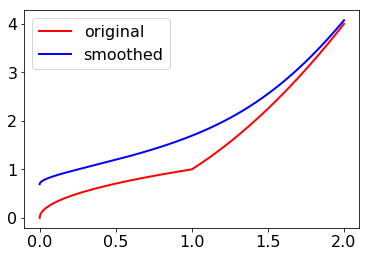

In [12]:
plt.plot(x, np.maximum(f(x),g(x)), linewidth=2, color='red', label="original");
plt.plot(x, np.log(np.exp(f(x))+np.exp(g(x))), linewidth=2, color='blue', label="smoothed");
plt.legend();

Earlier we said $|x|$ is the same as $\max(x, -x)$. Let's test it out:

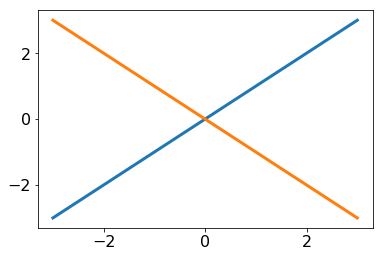

In [13]:
x = np.linspace(-3,3,1000)
f = lambda z: z
g = lambda z: -z
plt.plot(x,f(x), linewidth=3)
plt.plot(x,g(x), linewidth=3);

(-3.3, 3.3)

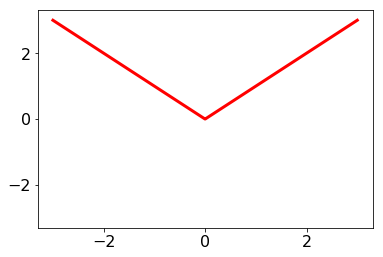

In [14]:
plt.plot(x, np.maximum(f(x),g(x)), linewidth=3, color='red');
plt.ylim(-3.3,3.3)

We can also plot the log-sum-exp approximation of this function:

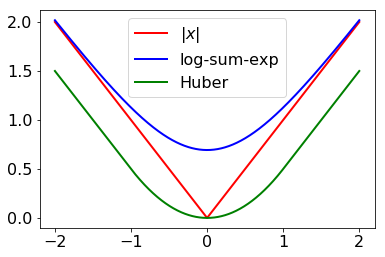

In [15]:
x = np.linspace(-2,2,1000)
plt.plot(x, np.maximum(x,-x), linewidth=2, color='red', label='$|x|$');
plt.plot(x, np.log(np.exp(x)+np.exp(-x)), linewidth=2, color='blue', label='log-sum-exp');
plt.plot(x, huber(x), color='green', linewidth=2, label="Huber")
plt.legend();

Both look reasonable.

## Summary of loss functions we've covered

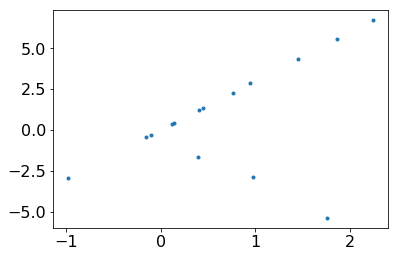

In [34]:
np.random.seed(0) # the demo is set up for this case 

n = 15
X, y = gen_outlier_data(n=n,Noutliers=3)
x = X.flatten()

# add column of 1's to X
X = np.concatenate((X, np.ones(n)[:,None]),axis=1)

# plot the points
plt.plot(x,y,'.');

In [35]:
# NO NEED TO READ THIS CODE

def plot_loss(loss_fun, X, y, wmin=-5, wmax=5, bmin=-5, bmax=5):
    m = 300
    w_lin = np.linspace(wmin, wmax, m)
    b_lin = np.linspace(bmin, bmax, m)
    w_grid, b_grid = np.meshgrid(w_lin, b_lin)
    w_flat = w_grid.flatten()
    b_flat = b_grid.flatten()
    
    pred = w_flat[None]*X[:,0][:,None] + b_flat[None]

    loss = np.sum(loss_fun(pred-y[:,None]),axis=0)
    if np.max(loss) > 1e5:
        print("Plotting log")
        loss = np.log(loss)
    loss_grid = np.reshape(loss,[m,m])

    CS = plt.contourf(w_grid, b_grid, loss_grid, nchunk=20)
    imin = np.argmin(loss_grid)
    plt.plot(w_flat[imin], b_flat[imin], 'r*', markersize=15)
    plt.xlabel('$w$')
    plt.ylabel('β')
    plt.clabel(CS, inline=1, fontsize=10)
#     plt.title('Loss in $w$-$β$ space')
#     plt.show()

def make_plots(error_fun, verbose=False, w0=None):
    loss_fun = lambda w: np.sum(error_fun(X@w-y))
    plt.figure(figsize=(15,4))
    plt.clf()
    grid = np.linspace(-5,5,1000)
    plt.subplot(1,3,1)
    plt.plot(grid, error_fun(grid));
    plt.title('The loss on each residual')
    plt.xlabel("$r_i$")
    plt.ylabel("$f_i(r_i)$")
    plt.subplot(1,3,2)
    plot_loss(error_fun,X,y)
    if w0 is None:
        w0 = npr.randn(2)
    ret = minimize(loss_fun, w0)
    if verbose:
        print(ret)
    w = ret.x
#     plt.scatter(w[0],w[1],s=200,facecolors='none',edgecolors='blue')
    plt.plot(w[0],w[1],'c*',markersize=15)
    plt.title('Loss contours in parameter space')
    plt.subplot(1,3,3)
    plt.plot(x,y,'.');
    plt.plot(x,X@w);
    plt.title('Fit model in data space')
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.tight_layout()
    return w

The **squared loss**:

$$f(w)=\sum_{i=1}^n (w^Tx_i-y_i)^2 = ||Xw-y||^2_2$$

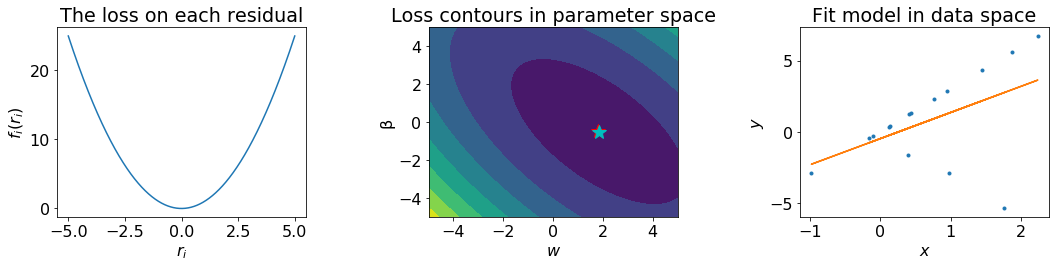

In [36]:
make_plots(np.square);

The **absolute value loss**:

$$f(w)=\sum_{i=1}^n \left|w^Tx_i-y_i\right| = \| Xw-y \|_1$$

Or the **Huber loss**.

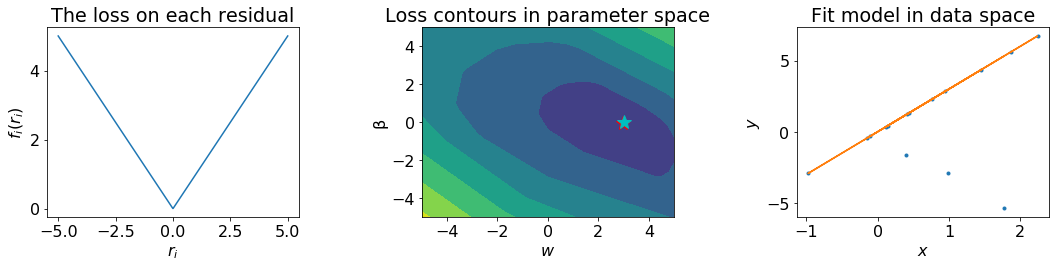

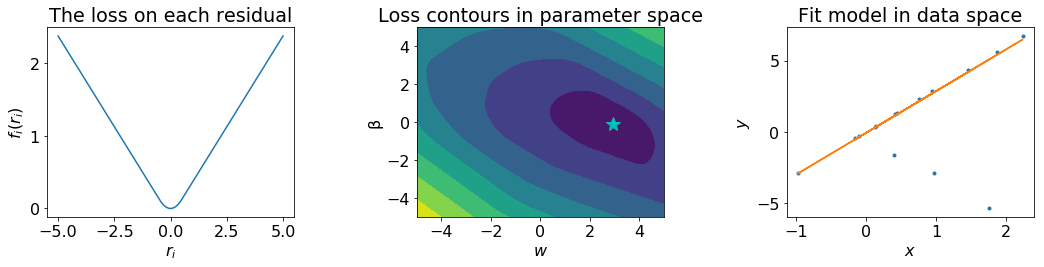

In [37]:
make_plots(np.abs);
make_plots(lambda r: scipy.special.huber(0.5,r)); # try playing with the "delta" parameter

(THE NEXT FEW "SLIDES", ON THE SUPER-ROBUST LOSS, ARE BONUS) 

A non-convex **"super-robust" loss**:

$$f(w)=\sum_{i=1}^n \left|w^Tx_i-y_i\right|^{1/2}$$

There are two problems here: 

1. non-smoothness
2. non-convexity 

Unlike the above cases, re-running the code yields different results because of the random initialization of the optimization procedure.

      fun: 26.785551554633855
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([1.65687561, 0.38880754])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 207
      nit: 0
     njev: 50
   status: 2
  success: False
        x: array([-0.88778575, -1.98079647])


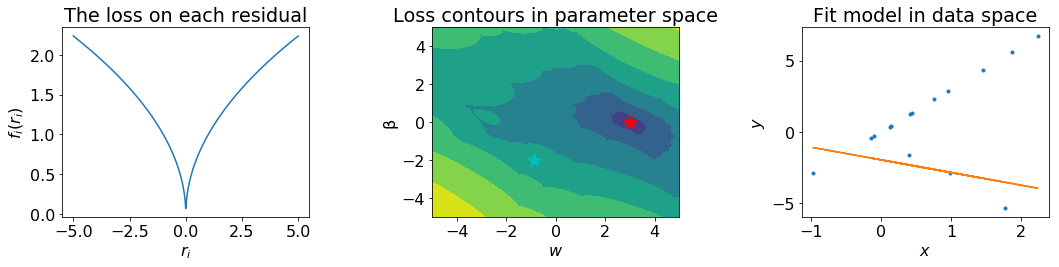

In [42]:
L12 = lambda z: np.sqrt(np.abs(z))
w = make_plots(L12, verbose=True)

This is clearly not minimizing the loss. Let's zoom in...

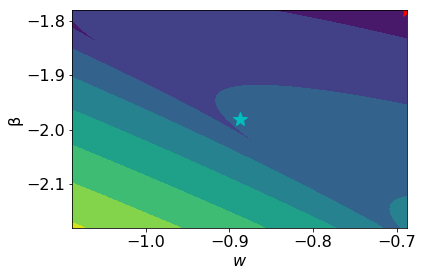

In [43]:
plot_loss(L12,X,y,wmin=w[0]-.2,wmax=w[0]+.2,bmin=w[1]-.2,bmax=w[1]+.2)
plt.plot(w[0],w[1],'c*',markersize=15);

We can evaluate the gradient at this $w$ to see if it is zero:

In [44]:
f = lambda w: np.sum(np.sqrt(np.abs(X@w-y)))
approx_fprime(w, f, 1e-6) # too lazy to take gradient by hand, using numerical differentiation

array([1.65684586, 0.38877597])

We have to be very careful about blindly applying optimization algorithms to functions that don't satisfy the assumptions of the optimizer.

We can also do a smooth approximation of the super-robust loss. It is smooth but non-convex. Though in this particular case there don't seem to be any local minima. You can fiddle with it and get local minima though.

In [46]:
# L12_smooth = lambda z: np.sqrt(np.log(np.exp(z)+np.exp(-z)))
# w = make_plots(L12_smooth, verbose=True)

The **brittle loss**:

$$f(w)=\max_{i=1,\ldots,n} \left|w^Tx_i-y_i\right| = \|Xw-y\|_{\infty}$$

Or its smooth approximation:

$$f(w)=\log \sum_{i=1}^n \exp\left(w^Tx_i-y_i\right)$$

Plotting log


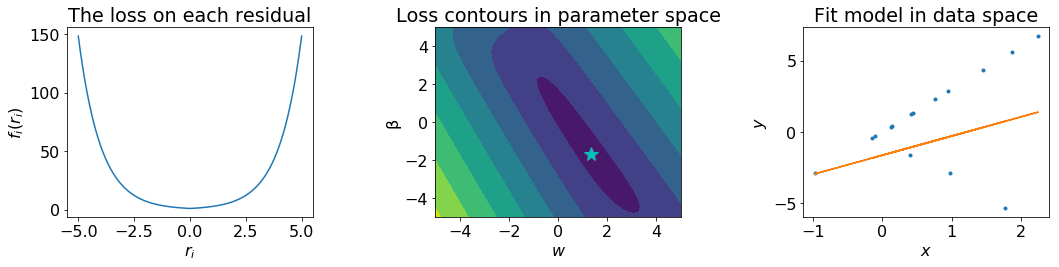

In [47]:
L_inf = lambda z: np.exp((np.abs(z)))
w = make_plots(L_inf)
# print(L_inf(X@w-y))

Notice the shape of the level sets. It says that if we increase the slope $w$ and decrease the intercept $\beta$, the loss doesn't change much. This is because by increasing the slope and decreasing the intercept the right amount, we keep our prediction roughly the same around $x=2$. In fact, these are only the predictions the loss cares about, since that's where the biggest residuals occur.

-----------


## Non-linear regression

- On many datasets, $y$ is not a linear function of $x$
- Can we use "linear regression" to fit **non-linear** models?
- Yes. You can do this by **changing the features**:

$$ X= \begin{bmatrix} 0.2 \\ -0.5 \\ 1 \\ 4 \end{bmatrix} \quad Z= \begin{bmatrix} 1 & 0.2 & (0.2)^2 \\ 1 & -0.5 & (-0.5)^2 \\ 1 & 1 & (1)^2 \\ 1 & 4 & (4)^2 \end{bmatrix} $$

Then prediction is $$y = v_1z_1 + v_2z_2 + v_3z_3$$

or, equivalently,

$$y = w_0 + w_1 x + w_2 x^2$$

(Reminder: when dealing with $X$ transformed to $Z$, we'll call the parameters $v$ instead of $w$.)

Big ideas here:

- You can fit a non-linear model "using linear regression"!!
- Still have access to the normal equations, all that good stuff.
- The "linear" in linear regression has two meanings:
  - The model is linear in $x$ (data view, no longer true)
  - The model is linear in $w$ (parameter view, still true!)
  - When using squared error, the gradient is also linear in $w$, which let's us just solve a linear system

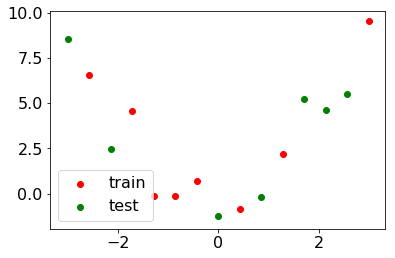

In [54]:
npr.seed(2)

n = 15
x = np.linspace(-3,3,n)
y = x**2 + npr.randn(n)

xtrain,xvalid,ytrain,yvalid = train_test_split(x,y,test_size=7)

plt.scatter(xtrain,ytrain,c='red', label='train');
plt.scatter(xvalid,yvalid,c='green',label='test');
plt.legend();

p  |  train err   | valid err |
---+--------------+-----------+
0         98.1           75.2
1         91.3           87.4
2          7.7           14.4
3          7.6           14.7
4          6.7           18.5
5          6.4           25.4
6          0.1         4784.8
7          0.0         7864.2


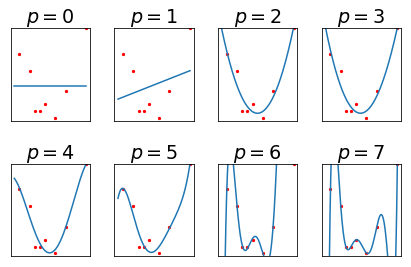

In [55]:
# You do not have to read this code. But, check out the one line marked below.

plt.figure()
plt.clf()

Xtrain = xtrain[:,None]
Xvalid = xvalid[:,None]

grid = np.linspace(np.min(x),np.max(x),1000)[:,None]

print("p  |  train err   | valid err |")
print("---+--------------+-----------+")
for p in range(8):
    pf = PolynomialFeatures(p)
    Z = pf.fit_transform(Xtrain)
    v = np.linalg.solve(Z.T @ Z, Z.T @ ytrain) # solve normal equations <--- HEY, LOOK, THIS IS THE SAME!!!!! 
    grid_poly = pf.fit_transform(grid)
    
    plt.subplot(2,4,p+1)
    plt.scatter(xtrain,ytrain,c='red', label='train',s=5);
#     plt.scatter(xvalid,yvalid,c='green',label='test',s=5);
    plt.plot(grid, grid_poly@v)
    train_pred = Z@v
    train_err = np.sum((ytrain-train_pred)**2)
    valid_pred = pf.transform(Xvalid)@v
    valid_err = np.sum((yvalid-valid_pred)**2)
    plt.title('$p=%d$'%p)
    plt.xticks(())
    plt.yticks(())
    plt.ylim((np.min(y),np.max(y)))
    print('%d %12.1f   %12.1f' % (p, train_err, valid_err))
plt.tight_layout();
#     print(max(abs(v)))
#     print(v)

In this case, based on the validation error, a degree of 2 or 3 seems appropriate. Which is comforting, since we generated the data from a quadratic function ($p=2$). 

Foreshadowing question: can we penalize higher $p$ so that we'd definitely choose $p=2$ here? 

## (bonus "slide") The basis function view

Our predictions are $y=Zv$. (We use the notation $v$ instead of $w$ when we've transformed our features into a new space.) Consider the column view of matrix multiplication:

$$ y_i = Zv= v_1 z_{i1} + v_2 z_{i2} + \ldots + v_d z_{id}$$

Now each $z^j$ is some function of the original $x$. For example, it might be different degree polynomials. So we can rewrite this as

$$ y_i = v_1 h_1(x_i) + v_2 h_2(x_i) + \ldots + v_d h_d(x_i)$$

where the $h_j$ are these different functions. These are called _basis functions_. We're not actually using the function as a continuous entity. Instead, we're evaluating it at the trainig points for training, and evaluating it at the test points for testing. 

## Beyond polynomials

We can have all sorts of features ("basis functions"), e.g. periodic functions. 

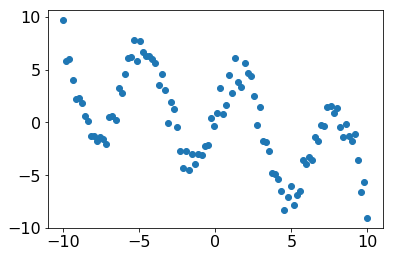

In [28]:
n = 100
x = np.linspace(-10,10,n)
y = -x/2 + 5*np.sin(x) + npr.randn(n)

plt.scatter(x,y);


In [29]:
X = x[:,None]
Z = np.concatenate((np.ones((n,1)), X, np.sin(X), np.cos(X)),axis=1)
Z[:10]

array([[  1.        , -10.        ,   0.54402111,  -0.83907153],
       [  1.        ,  -9.7979798 ,   0.36459873,  -0.93116473],
       [  1.        ,  -9.5959596 ,   0.17034683,  -0.98538417],
       [  1.        ,  -9.39393939,  -0.03083368,  -0.99952453],
       [  1.        ,  -9.19191919,  -0.23076008,  -0.97301068],
       [  1.        ,  -8.98989899,  -0.42130064,  -0.90692104],
       [  1.        ,  -8.78787879,  -0.59470541,  -0.8039437 ],
       [  1.        ,  -8.58585859,  -0.74392141,  -0.66826712],
       [  1.        ,  -8.38383838,  -0.86287948,  -0.50540974],
       [  1.        ,  -8.18181818,  -0.94674118,  -0.32199555]])

In [30]:
v = np.linalg.solve(Z.T @ Z, Z.T @ y)

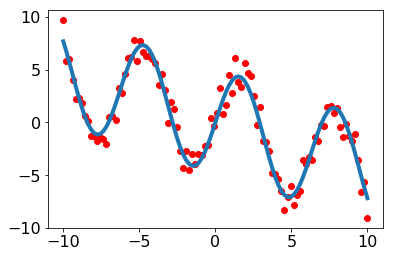

In [31]:
plt.scatter(x,y,c="red");
plt.plot(X, Z@v, linewidth=4);

Also, let's check out the weights!

In [32]:
v

array([ 0.13310162, -0.4733274 ,  4.96354555, -0.14207206])

The "true" weights (used to generate the data) are $[0, -0.5, 5, 0]$. We did a reasonable job of "recovering" them. And all using linear regression. (We could have used scikit-learn's `LinearRegression` if we wanted to.)